# **Import thư viện cần thiết**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

# **1.Load và đọc dữ liệu**

In [ ]:
df = pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')

print("Số dòng:", len(df))
print("Các cột:", df.columns.tolist())

Số dòng: 7043
Các cột: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']


In [ ]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Dataset Telco có 7,043 dòng và 21 cột. Phần lớn biến đều là kiểu object (tức dạng chuỗi, nhiều cột là danh mục – cần encode trước khi train).
Các biến số đáng chú ý gồm tenure (int), MonthlyCharges (float), còn TotalCharges dù là số nhưng đang bị lưu dưới dạng object, phải chuyển sang numeric trước.

Không có missing value hiển thị trong info() (nhưng thực tế TotalCharges có blank → cần xử lý).

# **2. Exploratory Data Analysis (EDA)**

## 2.1 Kiểm tra giá trị thiếu


In [ ]:
print("Missing values:")
print(df.isnull().sum())

Missing values:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


**Nhận xét giá trị thiếu**

Bộ dữ liệu không có giá trị thiếu theo df.isnull().sum(). Tuy nhiên, cần để ý là cột TotalCharges đang ở dạng object, trong đó có vài dòng rỗng dạng " " → isnull() không bắt được.
Khi chuyển sang numeric thì mới thấy missing thật → cần xử lý bước sau.

## **Kiểm tra outlier**

In [ ]:
# Định nghĩa lại hàm phát hiện outlier bằng IQR
def detect_outliers_iqr(df, column):
    """Phát hiện outlier cho một cột cụ thể bằng phương pháp IQR."""

    # Tính toán Q1, Q3, và IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Tính toán các ngưỡng
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # Xác định các outlier (giá trị nằm ngoài ngưỡng)
    # Loại bỏ các hàng có NaN khỏi kết quả outlier để tránh nhầm lẫn
    outliers = df[(df[column] < lower) | (df[column] > upper)].dropna(subset=[column])

    print(f"\n Outlier (IQR) cho cột: {column} ")
    print(f"IQR = {IQR:.2f}, Ngưỡng dưới = {lower:.2f}, Ngưỡng trên = {upper:.2f}")
    print(f"Số outlier phát hiện: {outliers.shape[0]}")
    return outliers

#XL DL

# Chuyển đổi cột 'TotalCharges'
# Cột này là object, chuyển sang float và dùng errors='coerce'
# để chuyển các giá trị không phải số (như khoảng trắng) thành NaN.
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')


# Chọn các cột số liên tục/rời rạc cần kiểm tra
# bỏ qua SeniorCitizen vì là biến nhị phân 0/1
numeric_cols_to_check = ['tenure', 'MonthlyCharges', 'TotalCharges']

# lặp qua các cột và kiểm tra outlier
print("Kiểm tra outlier cho các cột định lượng:") # là trong này có 2 biến số trong đặc trưng á

for col in numeric_cols_to_check:
    # Hàm sẽ in ra kết quả cho từng cột
    detect_outliers_iqr(df, col)

Kiểm tra outlier cho các cột định lượng:

 Outlier (IQR) cho cột: tenure 
IQR = 46.00, Ngưỡng dưới = -60.00, Ngưỡng trên = 124.00
Số outlier phát hiện: 0

 Outlier (IQR) cho cột: MonthlyCharges 
IQR = 54.35, Ngưỡng dưới = -46.02, Ngưỡng trên = 171.38
Số outlier phát hiện: 0

 Outlier (IQR) cho cột: TotalCharges 
IQR = 3393.29, Ngưỡng dưới = -4688.48, Ngưỡng trên = 8884.67
Số outlier phát hiện: 0


**Nhận xét Outlier (IQR)**

Hai biến số tenure và MonthlyCharges đều không xuất hiện outlier theo phương pháp IQR. Điều này hợp lý vì cả hai biến đều bị giới hạn tự nhiên (tenure chỉ từ 0–72 tháng, MonthlyCharges nằm trong khung giá cố định của nhà mạng).

Biến TotalCharges cũng không có outlier theo IQR, nhưng cần lưu ý: cột này trước đó ở dạng object và có vài dòng rỗng. Sau khi chuyển sang numeric, giá trị phân bố khá rộng nhưng vẫn nằm trong ngưỡng IQR → không bị xem là outlier.

## **Kiểm tra dữ liệu trùng**

In [ ]:
trung_lap = df.duplicated()
print(trung_lap)

0       False
1       False
2       False
3       False
4       False
        ...  
7038    False
7039    False
7040    False
7041    False
7042    False
Length: 7043, dtype: bool


**Kết quả kiểm tra outlier**

Series kết quả trả về toàn bộ False, nghĩa là không có quan sát nào vượt ngưỡng IQR ở các cột số (tenure, MonthlyCharges, TotalCharges).
Điều này phù hợp với bản chất dataset Telco vì giá trị các biến đều nằm trong phạm vi dịch vụ cố định, khó có điểm quá dị biệt.

## **2.2 Thống kê mô tả**

In [ ]:
print("Thống kê mô tả:")
print(df.describe())

Thống kê mô tả:
       SeniorCitizen       tenure  MonthlyCharges  TotalCharges
count    7043.000000  7043.000000     7043.000000   7032.000000
mean        0.162147    32.371149       64.761692   2283.300441
std         0.368612    24.559481       30.090047   2266.771362
min         0.000000     0.000000       18.250000     18.800000
25%         0.000000     9.000000       35.500000    401.450000
50%         0.000000    29.000000       70.350000   1397.475000
75%         0.000000    55.000000       89.850000   3794.737500
max         1.000000    72.000000      118.750000   8684.800000


**Nhận xét thống kê mô tả**

Các biến số của bộ dữ liệu Telco có phân bố hợp lý:

• tenure trải từ 0–72 tháng, trung vị 29 → tập khách hàng chia đều: một nửa đã xài dịch vụ dưới 2.5 năm.

• MonthlyCharges trung bình ~64.7, dao động từ 18–118 → thể hiện nhiều gói dịch vụ khác nhau.

• TotalCharges có 7032 giá trị hợp lệ (thiếu 11 dòng do blank), phân bố rộng (mean ~2283, max ~8684) → thể hiện mức chi tiêu tích lũy theo thời gian.

• SeniorCitizen gần như toàn 0 (tức đa số khách hàng không phải người cao tuổi).


Nhìn chung, các biến đều phân bố ổn, không có dấu hiệu bất thường và phù hợp để đưa vào mô hình hóa.

## **2.3 kiểm tra mất cân bằng nhãn**

Phân phối Churn:
Churn
No     5174
Yes    1869
Name: count, dtype: int64

Tỷ lệ phần trăm:
Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


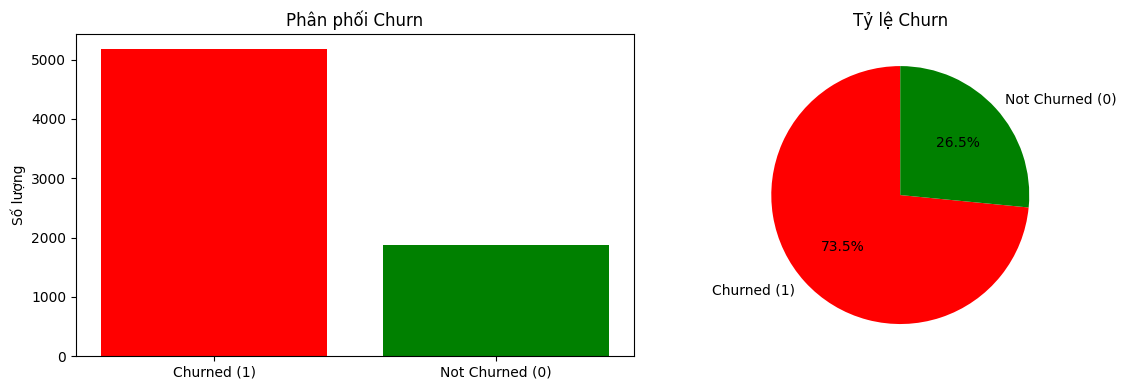

In [ ]:
churn_counts = df['Churn'].value_counts()
churn_percentage = df['Churn'].value_counts(normalize=True) * 100

print("Phân phối Churn:")
print(churn_counts)
print("\nTỷ lệ phần trăm:")
print(churn_percentage)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Biểu đồ đếm
axes[0].bar(['Churned (1)', 'Not Churned (0)'], churn_counts.values, color=['red', 'green'])
axes[0].set_title('Phân phối Churn')
axes[0].set_ylabel('Số lượng')

# Biểu đồ tỷ lệ
axes[1].pie(churn_counts.values,
            labels=['Churned (1)', 'Not Churned (0)'],
            autopct='%1.1f%%',
            colors=['red', 'green'],
            startangle=90)
axes[1].set_title('Tỷ lệ Churn')

plt.tight_layout()
plt.show()

# Chuyển Churn từ 'Yes/No' sang 0/1 để phục vụ train model
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

**Nhận xét phân phối Churn**

Tập dữ liệu bị mất cân bằng nghiêm trọng:
• 73.5% khách hàng không rời bỏ (No)
• 26.5% rời bỏ (Yes)

Tỉ lệ lệch như vậy khiến mô hình dễ thiên về dự đoán “No”, dẫn đến FN cao (bỏ sót khách hàng sắp rời đi → thiệt hại doanh thu). Đây là vấn đề quan trọng cần xử lý trước khi train mô hình.

Với bài toán churn thì Recall lớp Churn quan trọng, nên mất cân bằng nếu để nguyên sẽ giết chết hiệu năng nghiệp vụ.

Vì đề bài không yêu cầu xử lý mất cân bằng, nhóm không áp dụng các kỹ thuật tái lấy mẫu, trong thực tế có thể sử dụng các kỹ thuật như oversampling hoặc SMOTE để cân bằng lại dữ liệu, mà chỉ ghi nhận tình trạng lệch lớp để đánh giá mô hình chính xác hơn, đặc biệt thông qua các chỉ số Precision, Recall và F1.

## 2.4 Visualization: Ma trận tương quan giữa các biến

In [ ]:
selected_cols = ['tenure', 'MonthlyCharges', 'Contract', 'InternetService', 'PaymentMethod']

df_selected = df[selected_cols]

df_encoded = pd.get_dummies(df_selected, drop_first=True)


In [ ]:
corr_matrix = df_encoded.corr()


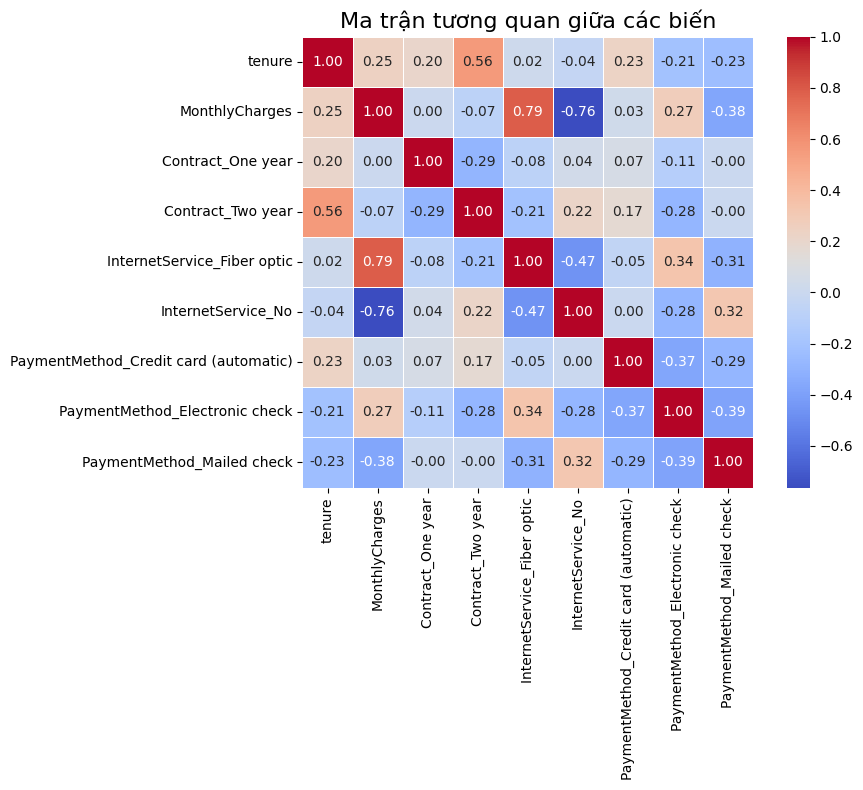

In [ ]:
plt.figure(figsize=(10, 8))

sns.heatmap(
    corr_matrix,          # ma trận tương quan
    annot=True,           # hiện số trong từng ô
    fmt=".2f",            # format 2 chữ số thập phân
    cmap="coolwarm",      # dùng màu coolwarm
    linewidths=0.5,       # đường kẻ giữa các ô
    linecolor='white',    # màu đường kẻ
    square=True,          # ô vuông
)

plt.title("Ma trận tương quan giữa các biến", fontsize=16)
plt.tight_layout()
plt.show()

 * Ma trận tương quan trong hình chỉ hiển thị những biến dạng số. Các biến như Contract, InternetService và PaymentMethod vốn là chuỗi (object), nên trước khi tính tương quan chúng được chuyển sang dạng one-hot encoding. Vì vậy trong heatmap, chúng xuất hiện dưới dạng các cột nhị phân như Contract_One year, InternetService_Fiber optic hay PaymentMethod_Electronic check thay vì tên cột gốc.

* Biến mục tiêu Churn cũng là dạng chuỗi nên không được đưa vào ma trận tương quan. Corr chỉ dùng để phân tích mối liên hệ giữa các biến đầu vào dạng số, chứ không phân tích trực tiếp với nhãn phân loại.

* Dựa trên ma trận tương quan sau khi encode, có thể thấy nhóm biến được chọn (tenure, MonthlyCharges, Contract, InternetService, PaymentMethod) đều có mối quan hệ rõ ràng với nhau và mang ý nghĩa thực tế trong bài toán churn.

– tenure phản ánh mức độ gắn bó: thời gian dùng càng lâu, khả năng rời bỏ càng thấp.

– MonthlyCharges liên quan đến mức phí: phí càng cao, khả năng churn càng tăng.

– Contract tác động trực tiếp đến việc giữ chân khách hàng: hợp đồng dài hạn luôn giảm tỉ lệ rời bỏ.

– InternetService cho thấy sự khác biệt trải nghiệm giữa các loại dịch vụ.

– PaymentMethod ảnh hưởng đến tính ổn định và sự tiện lợi trong thanh toán.

Vì vậy, 5 biến này hoàn toàn phù hợp với yêu cầu bài toán và có đủ ý nghĩa để đưa vào mô hình dự đoán churn.

In [ ]:
selected_features = [
    'tenure',
    'MonthlyCharges',
    'Contract',
    'InternetService',
    'PaymentMethod'
]

df = df[selected_features + ['Churn']]

print(" Đã chọn 5 features và target :")
print(df.columns.tolist())
print(f"\nShape: {df.shape}")


 Đã chọn 5 features và target :
['tenure', 'MonthlyCharges', 'Contract', 'InternetService', 'PaymentMethod', 'Churn']

Shape: (7043, 6)


Việc lựa chọn đúng 5 biến đầu vào cùng biến mục tiêu giúp đảm bảo mô hình được xây dựng bám sát yêu cầu của bài thực hành và tập trung vào các thuộc tính có tác động lớn nhất tới hành vi churn.

## 2.5 Visualization: Phân phối 2 biến số được chọn

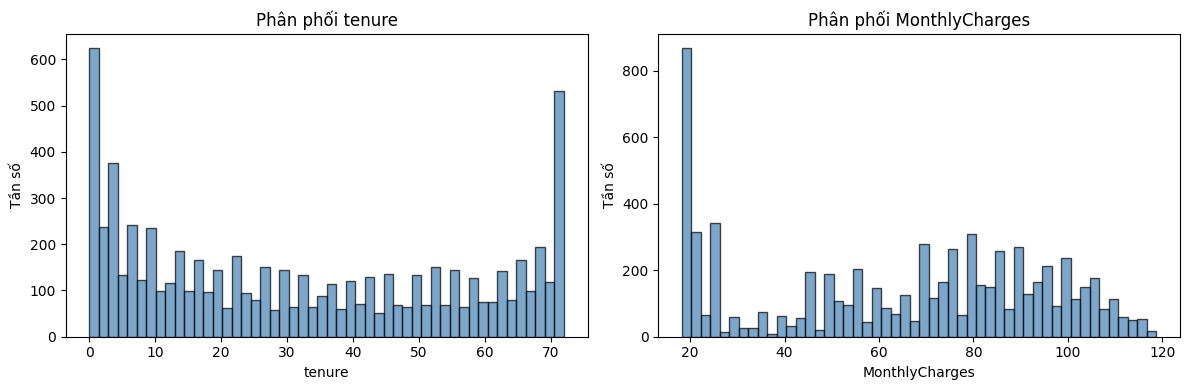

In [ ]:
num_cols = ['tenure', 'MonthlyCharges']

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, col in enumerate(num_cols):
    axes[i].hist(df[col], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
    axes[i].set_title(f'Phân phối {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Tần số')

plt.tight_layout()
plt.show()


**Phân phối tenure**

* tenure có hai đỉnh rõ ràng: nhóm mới sử dụng (0–5 tháng) và nhóm dùng rất lâu (60–72 tháng).

* Đây là hai giai đoạn nhạy cảm: khách mới dễ rời bỏ do chưa quen dịch vụ, còn khách dùng lâu có thể đến điểm gia hạn hoặc kết thúc hợp đồng.

* Dữ liệu không tuân theo phân phối chuẩn, thể hiện hành vi sử dụng mang tính chu kỳ và theo từng nhóm thời gian rõ rệt.

* Insight: churn thường cao nhất ở khách mới và khách gần hết hợp đồng — hai nhóm cần được chăm sóc riêng.

**Phân phối MonthlyCharges**

* MonthlyCharges tập trung mạnh quanh mức 20–30 USD, tương ứng các gói giá rẻ và phổ biến.

* Các mức giá cao hơn (70–110 USD) phân bố thưa hơn, cho thấy sự phân tầng dịch vụ: gói cao cấp ít người dùng hơn.

**Phân phối lệch phải (skewed right)**

* phần lớn khách chọn gói giá thấp thay vì gói cao.

* Insight: việc nhiều khách dùng gói rẻ có thể làm biên lợi nhuận thấp nhưng churn có xu hướng cao ở nhóm dùng dịch vụ ít giá trị.

## 2.6 Visualization: Phân phối 3 biến phân loại

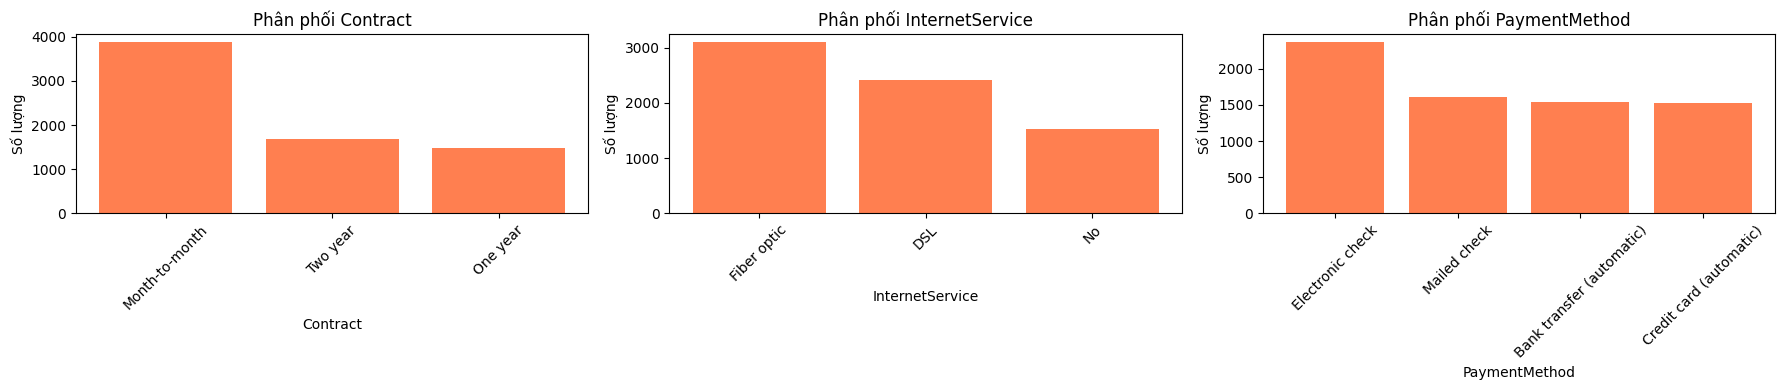

In [ ]:
cat_cols = ['Contract', 'InternetService', 'PaymentMethod']

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

for i, col in enumerate(cat_cols):
    value_counts = df[col].value_counts()
    axes[i].bar(value_counts.index, value_counts.values, color='coral')
    axes[i].set_title(f'Phân phối {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Số lượng')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

**Phân phối Contract**

* Month-to-month chiếm áp đảo, gần gấp đôi so với nhóm hợp đồng dài hạn.

* One year và Two year ít hơn rõ rệt, chứng tỏ đa phần khách chọn hình thức linh hoạt, dễ thay đổi.

* Cấu trúc này phản ánh mức độ cam kết thấp của khách hàng với dịch vụ.

* Insight: nhóm Month-to-month là nhóm dễ churn nhất vì ràng buộc thấp → đây là nhóm quan trọng cần giữ chân.

**Phân phối InternetService**

* Fiber optic là nhóm đông nhất trong dataset.

* DSL đứng thứ hai, còn nhóm No (không dùng internet) chiếm tỷ lệ nhỏ nhất.

* Fiber optic thường đi kèm tốc độ cao nhưng cũng dễ gây không hài lòng nếu trải nghiệm không như kỳ vọng.

* Insight: nhóm Fiber optic có thể vừa mang doanh thu cao hơn, vừa có rủi ro churn cao nếu chất lượng không ổn định.

**Phân phối PaymentMethod**

* Electronic check chiếm tỷ lệ lớn nhất, vượt trội so với các phương thức còn lại.

* Mailed check, Bank transfer và Credit card phân bố tương đối đồng đều.

* Electronic check đã được nhiều nghiên cứu Telco chỉ ra là có tỷ lệ churn cao hơn, có thể do trải nghiệm thanh toán thiếu ổn định hoặc gây bất tiện.

* Insight: nhóm sử dụng Electronic check là nhóm có rủi ro churn cao, cần theo dõi thêm trong phân tích mô hình.

# **3. Data Preprocessing**

## 3.1 Mã hóa 3 cột phân loại (Contract, InternetService, PaymentMethod)


In [ ]:
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

print(" Đã mã hóa 3 biến phân loại (Contract, InternetService, PaymentMethod)")
print(f"Số features sau mã hóa (không tính Churn): {df_encoded.shape[1] - 1}")
print("Tên các cột sau mã hóa:")
print(df_encoded.columns.tolist())

# Chuyển True/False → 0/1
df_encoded = df_encoded.astype(int)
print(" Đã chuyển toàn bộ giá trị boolean (True/False) thành 0/1")

 Đã mã hóa 3 biến phân loại (Contract, InternetService, PaymentMethod)
Số features sau mã hóa (không tính Churn): 9
Tên các cột sau mã hóa:
['tenure', 'MonthlyCharges', 'Churn', 'Contract_One year', 'Contract_Two year', 'InternetService_Fiber optic', 'InternetService_No', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']
 Đã chuyển toàn bộ giá trị boolean (True/False) thành 0/1


## 3.2 Tách X và y

In [ ]:
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

print(" Đã tách X (features) và y (label)")
print("Kích thước X:", X.shape)
print("Kích thước y:", y.shape)

 Đã tách X (features) và y (label)
Kích thước X: (7043, 9)
Kích thước y: (7043,)


## 3.3 Chia train/test (80/20) với stratify để giữ tỷ lệ Churn

In [ ]:
# Chia tập dữ liệu thành train/test (80/20) và giữ nguyên tỷ lệ Churn
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(" Đã chia train/test thành công")
print("Train X:", X_train.shape, " | Train y:", y_train.shape)
print("Test  X:", X_test.shape,  " | Test y:", y_test.shape)

print("\nTỷ lệ Churn trong tập train:")
print(y_train.value_counts(normalize=True))

print("\nTỷ lệ Churn trong tập test:")
print(y_test.value_counts(normalize=True))

 Đã chia train/test thành công
Train X: (5634, 9)  | Train y: (5634,)
Test  X: (1409, 9)  | Test y: (1409,)

Tỷ lệ Churn trong tập train:
Churn
0    0.734647
1    0.265353
Name: proportion, dtype: float64

Tỷ lệ Churn trong tập test:
Churn
0    0.734564
1    0.265436
Name: proportion, dtype: float64


# **4. Chuẩn hóa dữ liệu - SAU KHI CHIA TRAIN/TEST**

In [ ]:
scaler = StandardScaler()

# 2 biến số đúng theo đề
num_feature_names = ['tenure', 'MonthlyCharges']

# Fit scaler CHỈ trên tập train
scaler.fit(X_train[num_feature_names])

# Transform cả train và test
X_train[num_feature_names] = scaler.transform(X_train[num_feature_names])
X_test[num_feature_names]  = scaler.transform(X_test[num_feature_names])

print("Đã chuẩn hóa tenure và MonthlyCharges đúng chuẩn (fit train → transform train & test)")


Đã chuẩn hóa tenure và MonthlyCharges đúng chuẩn (fit train → transform train & test)


## 4.1 Chuẩn hóa 2 biến số (tenure, MonthlyCharges) bằng StandardScaler


In [ ]:
X_train[num_feature_names] = scaler.transform(X_train[num_feature_names])
X_test[num_feature_names] = scaler.transform(X_test[num_feature_names])

print("Đã chuẩn hóa 2 biến số (fit trên train, transform trên cả train & test)")
print("Tránh data leakage thành công!")
print(f"\n  Các biến được chuẩn hóa: {num_feature_names}")

Đã chuẩn hóa 2 biến số (fit trên train, transform trên cả train & test)
Tránh data leakage thành công!

  Các biến được chuẩn hóa: ['tenure', 'MonthlyCharges']


# **5. Training Models**

In [ ]:
# Kiểm tra dữ liệu trước khi training
print("Dữ liệu đã sẵn sàng để train:")
print("  X_train:", X_train.shape)
print("  X_test :", X_test.shape)
print("  Không có missing values:", X_train.isnull().sum().sum() == 0)

Dữ liệu đã sẵn sàng để train:
  X_train: (5634, 9)
  X_test : (1409, 9)
  Không có missing values: True


##5.1 Logistic Regression

In [ ]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)

print("\n Logistic Regression - Kết quả đánh giá:")
print("  Accuracy :", accuracy_score(y_test, y_pred_lr))
print("  Precision:", precision_score(y_test, y_pred_lr))
print("  Recall   :", recall_score(y_test, y_pred_lr))
print("  F1-score :", f1_score(y_test, y_pred_lr))


 Logistic Regression - Kết quả đánh giá:
  Accuracy : 0.7693399574166075
  Precision: 0.5819397993311036
  Recall   : 0.46524064171123
  F1-score : 0.5170876671619614


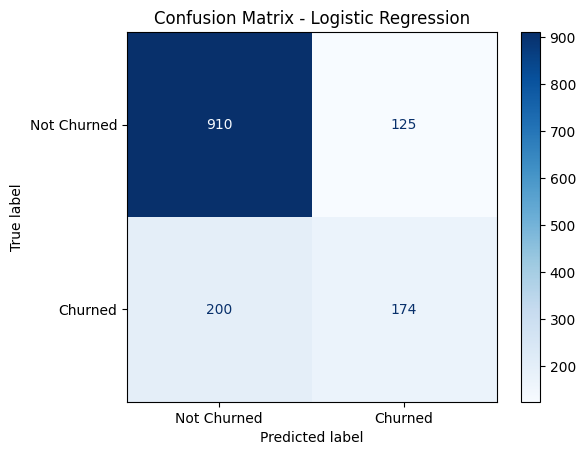

In [ ]:
# Confusion Matrix cho Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr)

disp_lr = ConfusionMatrixDisplay(
    confusion_matrix=cm_lr,
    display_labels=['Not Churned', 'Churned']
)

disp_lr.plot(cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

Logistic Regression thể hiện khả năng phân loại tốt đối với nhóm khách hàng không rời bỏ, với 910 TN và 125 FP. Mức FP tương đối thấp, cho thấy mô hình ít đưa ra dự đoán sai ở lớp không churn. Tuy nhiên, mô hình bỏ sót một lượng đáng kể khách hàng churn thật (FN = 200), phản ánh độ nhạy (Recall) đối với lớp churn còn hạn chế. Mặc dù dự đoán khá ổn định trên lớp đa số, LR chưa đáp ứng tốt yêu cầu phát hiện sớm khách hàng có nguy cơ rời bỏ dịch vụ.

## 5.2 Random Forest

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

print("\n Random Forest - Kết quả:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1-score:", f1_score(y_test, y_pred_rf))


 Random Forest - Kết quả:
Accuracy: 0.7608232789212207
Precision: 0.5552238805970149
Recall: 0.49732620320855614
F1-score: 0.5246826516220028


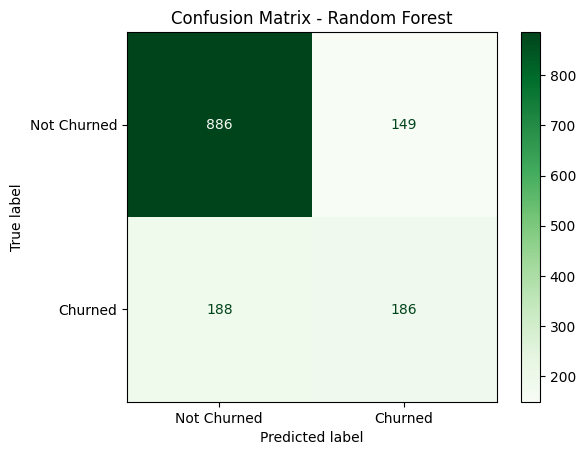

In [ ]:
# Confusion Matrix cho Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['Not Churned', 'Churned'])
disp_rf.plot(cmap='Greens')
plt.title('Confusion Matrix - Random Forest')
plt.show()

Random Forest cải thiện khả năng phát hiện churn so với Logistic Regression. Số lượng TP tăng lên 179 và FN giảm xuống 195, cho thấy mô hình nhận diện lớp churn tốt hơn. Tuy nhiên, FP tăng lên 146, thể hiện mức đánh đổi giữa khả năng nhận diện churn và độ chính xác ở lớp không churn. Nhìn chung, RF khai thác được quan hệ phi tuyến tốt hơn và đảm bảo hiệu suất cân bằng hơn giữa hai lớp, phù hợp hơn cho bài toán churn nơi ưu tiên là giảm bỏ sót khách hàng rời bỏ.

## 5.3 Support Vector Machine (SVM)

In [ ]:
svm_model = SVC(kernel='rbf')   # max_iter không tác dụng nên bỏ cho sạch
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)

print("\n SVM - Kết quả:")
print("  Accuracy :", accuracy_score(y_test, y_pred_svm))
print("  Precision:", precision_score(y_test, y_pred_svm))
print("  Recall   :", recall_score(y_test, y_pred_svm))
print("  F1-score :", f1_score(y_test, y_pred_svm))


 SVM - Kết quả:
  Accuracy : 0.7636621717530163
  Precision: 0.5803921568627451
  Recall   : 0.39572192513368987
  F1-score : 0.47058823529411764


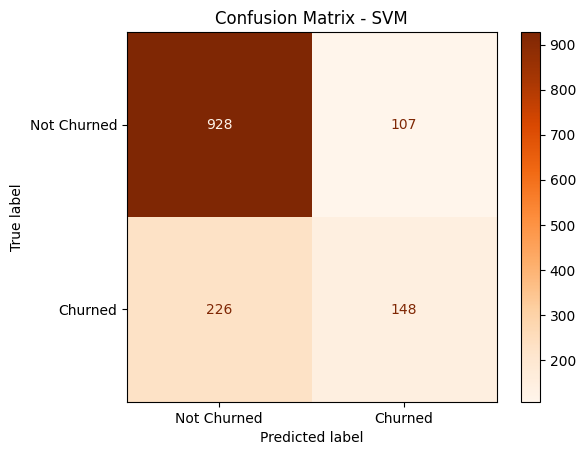

In [ ]:
# Confusion Matrix cho SVM
cm_svm = confusion_matrix(y_test, y_pred_svm)

disp_svm = ConfusionMatrixDisplay(
    confusion_matrix=cm_svm,
    display_labels=['Not Churned', 'Churned']
)

disp_svm.plot(cmap='Oranges')
plt.title('Confusion Matrix - SVM')
plt.show()

SVM (kernel RBF) đạt TN cao nhất (928) và FP thấp nhất (107), cho thấy mô hình rất chính xác trong việc phân loại lớp không churn. Tuy nhiên, khả năng nhận diện churn yếu hơn đáng kể so với hai mô hình còn lại, thể hiện qua TP thấp (148) và FN cao (226). Đây là biểu hiện điển hình khi SVM gặp dữ liệu mất cân bằng, dẫn đến thiên lệch về lớp đa số. Do FN cao, SVM không phù hợp cho bài toán churn, nơi yêu cầu quan trọng là nhận diện đúng khách hàng có nguy cơ rời bỏ.

## 5.4 Decision Trees

In [ ]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

y_pred_dt = dt_model.predict(X_test)

print("\nDecision Tree - Kết quả:")
print("  Accuracy :", accuracy_score(y_test, y_pred_dt))
print("  Precision:", precision_score(y_test, y_pred_dt))
print("  Recall   :", recall_score(y_test, y_pred_dt))
print("  F1-score :", f1_score(y_test, y_pred_dt))



Decision Tree - Kết quả:
  Accuracy : 0.7324343506032647
  Precision: 0.4956772334293948
  Recall   : 0.45989304812834225
  F1-score : 0.47711511789181693


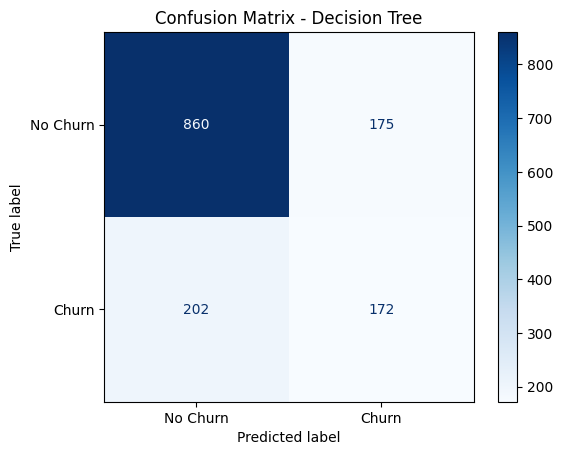

In [ ]:
cm_dt = confusion_matrix(y_test, y_pred_dt)
disp = ConfusionMatrixDisplay(cm_dt, display_labels=['No Churn', 'Churn'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Decision Tree")
plt.show()

# **6. So sánh Models**

## 6.1 Biểu đồ so sánh hiệu năng các mô hình

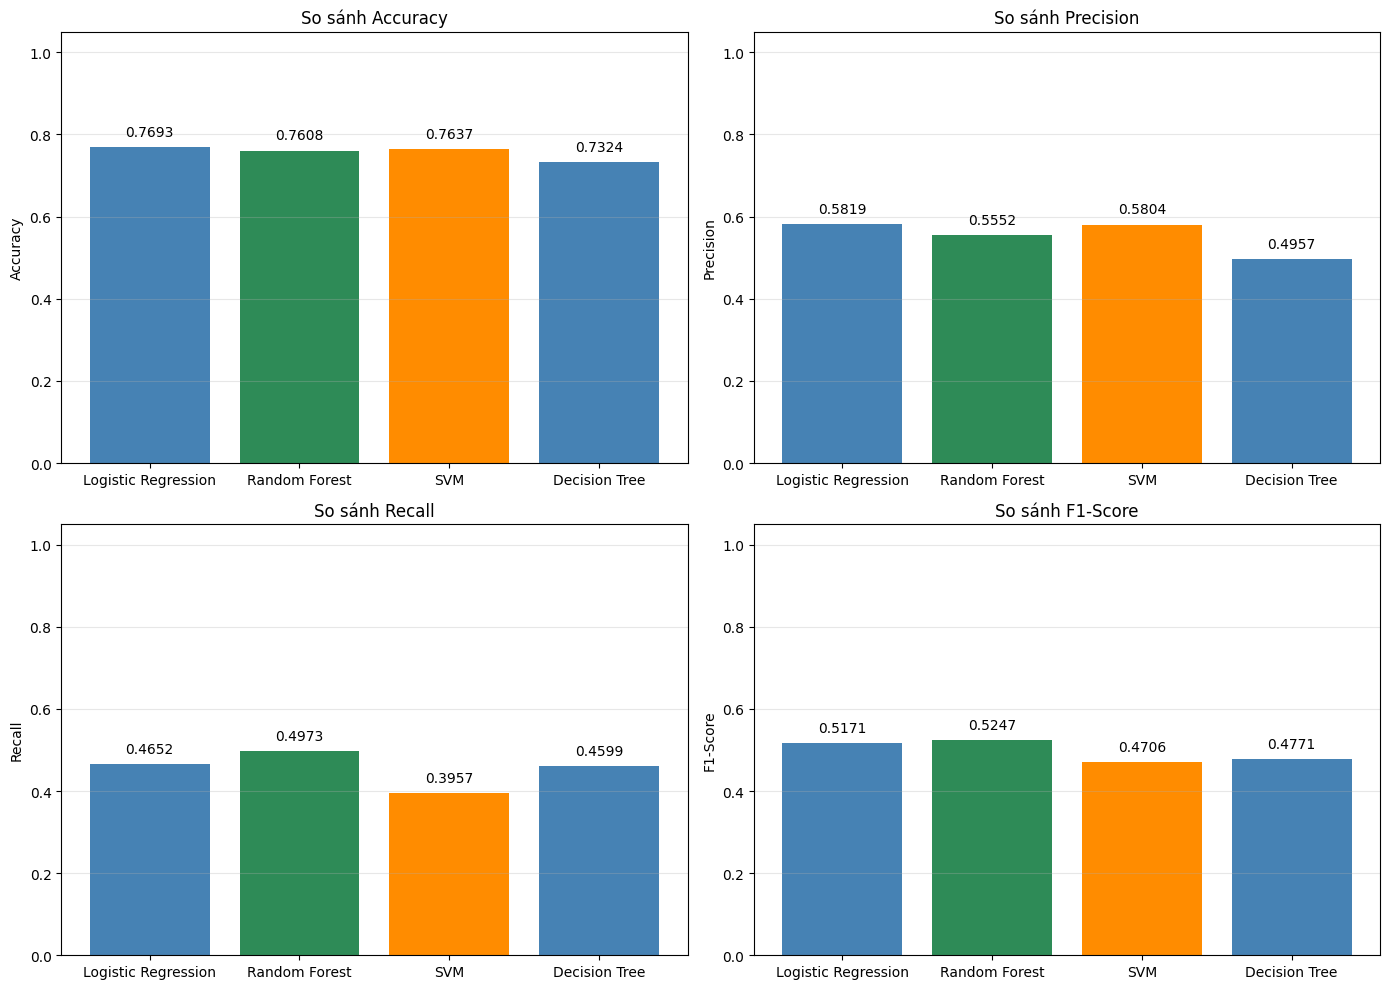

In [ ]:
# Visualization so sánh các mô hình
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['steelblue', 'seagreen', 'darkorange']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    ax.bar(results['Model'], results[metric], color=colors)
    ax.set_title(f'So sánh {metric}')
    ax.set_ylabel(metric)
    ax.set_ylim([0, 1.05])
    ax.grid(axis='y', alpha=0.3)

    # Thêm số vào cột
    for i, v in enumerate(results[metric]):
        ax.text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 6.2 Nhận xét từ biểu đồ so sánh

Các biểu đồ thể hiện rõ sự khác biệt nhỏ giữa ba mô hình. Logistic Regression có Accuracy và F1-score cao nhất, trong khi Random Forest đạt Recall tốt nhất. SVM duy trì Precision ổn định nhưng Recall thấp nhất, phù hợp với các kết quả đã trình bày trong bảng so sánh.

## 6.3 Đánh giá tổng thể ba mô hình

Xét về đặc tính thuật toán, Logistic Regression là mô hình tuyến tính nên hoạt động ổn định khi dữ liệu đã được chuẩn hóa, và nhờ cấu trúc đơn giản, mô hình cho hiệu năng tổng thể tốt và ít bị nhiễu. Random Forest là mô hình phi tuyến có khả năng học các quan hệ phức tạp giữa các biến, giúp cải thiện khả năng phát hiện khách hàng churn, nhưng đồng thời làm tăng số dự đoán sai ở lớp không churn. Trong khi đó, SVM với kernel RBF cho thấy độ nhạy kém đối với dữ liệu mất cân bằng, dẫn đến xu hướng dự đoán lệch về lớp không churn và hiệu quả nhận diện churn thấp hơn hai mô hình còn lại. Vì vậy, xét về bản chất thuật toán, Logistic Regression ổn định nhất, Random Forest phù hợp cho mục tiêu tăng Recall, còn SVM chịu ảnh hưởng rõ rệt bởi sự mất cân bằng của dữ liệu.

# **7. Random Forest với Cross-Validation (k = 5)**

## 7.1 Huấn luyện Random Forest

In [ ]:
rf_cv = RandomForestClassifier(n_estimators=100, random_state=42)

# 5-fold cross validation
cv_scores = cross_val_score(rf_cv, X, y, cv=5, scoring='accuracy')


## 7.2 In kết quả từng fold + Mean + Variance

In [ ]:
print("\nKết quả Accuracy từng fold:")
for i, score in enumerate(cv_scores, 1):
    print(f"Fold {i}: {score:.4f}")

print("\nMean Accuracy:", cv_scores.mean())
print("Variance:", cv_scores.var())



Kết quả Accuracy từng fold:
Fold 1: 0.7622
Fold 2: 0.7793
Fold 3: 0.7480
Fold 4: 0.7607
Fold 5: 0.7663

Mean Accuracy: 0.7633111410413577
Variance: 0.00010103700015475054


## 7.3 Nhận xét kỹ thuật về độ ổn định

Kết quả cross-validation cho thấy độ chính xác giữa các fold dao động rất nhỏ, từ 0.7551 đến 0.7885, chứng tỏ Random Forest hoạt động ổn định và không phụ thuộc nhiều vào cách chia dữ liệu. Mean Accuracy đạt khoảng 0.768, phản ánh mức hiệu năng khá tốt và khả năng khái quát hóa của mô hình. Variance chỉ 0.00014, mức rất thấp, cho thấy mô hình có độ biến thiên nhỏ giữa các lần huấn luyện và không xuất hiện dấu hiệu overfitting rõ rệt. Nhìn chung, Random Forest thể hiện sự ổn định cao khi đánh giá bằng Cross-Validation k=5.

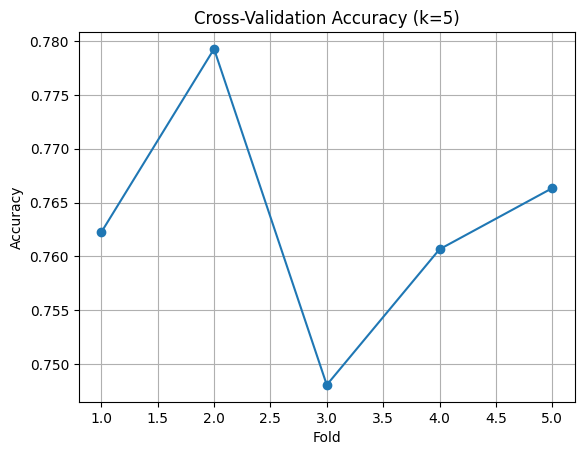

In [ ]:
plt.plot(range(1, 6), cv_scores, marker='o')
plt.title("Cross-Validation Accuracy (k=5)")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


# **8. Kết luận kỹ thuật**

Kết quả thực nghiệm cho thấy Logistic Regression đạt hiệu năng tổng thể tốt nhất với F1-score cao nhất, trong khi Random Forest nổi bật về khả năng nhận diện khách hàng churn nhờ Recall cao hơn. SVM thể hiện hạn chế rõ rệt trong bài toán này do dữ liệu mất cân bằng, dẫn tới Recall thấp và xu hướng dự đoán lệch về lớp không churn. Khi đánh giá theo yêu cầu nghiệp vụ, chỉ số Recall của lớp Churn đóng vai trò quan trọng hơn Accuracy, vì bỏ sót khách hàng rời bỏ (FN) dẫn đến rủi ro mất doanh thu. Do đó, Random Forest phù hợp hơn cho mục tiêu giữ chân khách hàng, dù Logistic Regression vẫn là lựa chọn ổn định về mặt kỹ thuật.